# Setup

In [1]:
import os

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from dotenv import load_dotenv

plt.style.use("ggplot")
plt.rcParams.update({
    "font.size": 8,
    "figure.figsize": (5, 3),
})

%matplotlib inline

## Environment variables

In [2]:
load_dotenv()

True

## PostgreSQL configurations

In [3]:
pg_user = os.getenv("PGUSER")
pg_password = os.getenv("PGPASSWORD")
pg_host = os.getenv("PGHOST", "localhost")
pg_port = os.getenv("PGPORT", "5432")
pg_database = os.getenv("PGDATABASE")

pg_conn_str = f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_database}"

## MinIO configurations

In [4]:
s3_endpoint = "http://localhost:9000"
s3_region = "us-east-1"
s3_access_key_id = os.getenv("MINIO_ROOT_USER", "admin")
s3_secret_access_key = os.getenv("MINIO_ROOT_PASSWORD", "admin")

# Analytics and time series

## pg_mooncake

The storage layer of `pg_mooncake` is Delta Lake, so we should be able to access the tables externally.

### Retrieve storage path

In [5]:
table_path = pd.read_sql_query(
    sql="""
        SELECT path
        FROM mooncake.columnstore_tables
        WHERE table_name = 'youtube'
    """,
    con=pg_conn_str,
).loc[0, "path"]

table_path

's3://lakehouse/mooncake_datalabtech_youtube_111812/'

### Load using DuckDB

After setting up the secret to connect to MinIO, we attempt to count the number of rows in the `youtube` table.

In [6]:
con = duckdb.connect()

con.install_extension("httpfs")
con.load_extension("httpfs")

con.execute(
    f"""
    CREATE SECRET (
      TYPE S3,
      KEY_ID '{s3_access_key_id}',
      SECRET '{s3_secret_access_key}',
      ENDPOINT '{s3_endpoint.lstrip("http://")}',
      REGION '{s3_region}',
      USE_SSL false,
      URL_STYLE 'path'
    )
    """
)

result = con.execute("SELECT count(*) FROM delta_scan(?)", (table_path,)).fetchone()
print(result)

con.close()

(1541128,)


## timescaledb_toolkit

In [7]:
pd.read_sql_query(sql="SELECT count(*) FROM youtube_ts", con=pg_conn_str)

,count
0,1541128


### Hyperfunctions

In [8]:
weekly_smoothed_comments = pd.read_sql_query(sql=f"""
        SELECT week_start, orig_comments, lttb_comments, asap_comments
        FROM youtube_weekly_smoothed_comments()
        ORDER BY week_start
    """,
    con=pg_conn_str,
    parse_dates=["week_start"],
)

weekly_smoothed_comments.head(5)

,week_start,orig_comments,lttb_comments,asap_comments
0,2019-04-15,5760490,3111299,5915279
1,2019-04-22,4999494,418365,4628085
2,2019-04-29,3523526,302759,3985737
3,2019-05-06,2190732,284205,2779309
4,2019-05-13,2645112,507164,3111250


The plot below shows that LTTB (Largest Triangle Three Buckets), a method for downsampling, does a good job capturing the trend but not the magnitude. On the other hand, ASAP (Automatic Smoothing for Attention Prioritization), a method for smoothing, not only seems to downsample, but it also does a poorer job of capturing the trend.

<Axes: title={'center': 'Original vs downsampled no. comments'}>

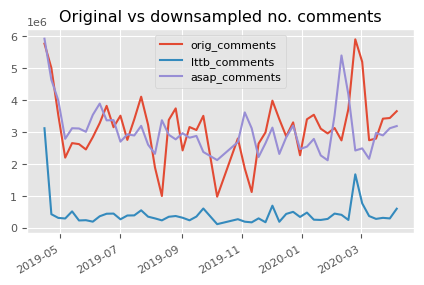

In [9]:
weekly_smoothed_comments.plot(
    title="Original vs downsampled no. comments",
    x="week_start",
    xlabel="",
)

### Dislikes distributions

In [10]:
week_start = '2019-12-02'

weekly_dislikes = pd.read_sql_query(sql=f"""
        SELECT dislikes, norm_dislikes
        FROM youtube_ts_weekly_features
        JOIN youtube_ts_weekly_stats
        USING (bucket, ytvideoid)
        WHERE date_trunc('week', bucket)::date = '{week_start}'
    """,
    con=pg_conn_str,
)

weekly_dislikes

,dislikes,norm_dislikes
0,517,-0.480453
1,756,-0.163459
2,321,-0.906547
3,5945,1.253064
4,2482,0.710685
...,...,...
352,316,-0.921145
353,590,-0.368054
354,363,-0.793470
355,1511,0.366218


#### Original value

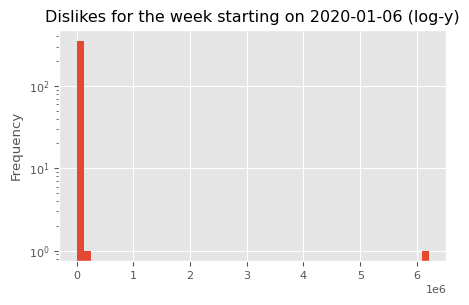

In [11]:
weekly_dislikes["dislikes"].plot.hist(
    title="Dislikes for the week starting on 2020-01-06 (log-y)",
    bins=50,
    logy=True,
);

In [12]:
weekly_dislikes["dislikes"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    3.570000e+02
mean     2.076377e+04
std      3.286009e+05
min      3.500000e+01
25%      4.390000e+02
50%      8.820000e+02
75%      2.296000e+03
90%      6.073000e+03
95%      9.928000e+03
99%      6.856856e+04
max      6.208477e+06
Name: dislikes, dtype: float64

Let's improve readability by excluding the 95th percentile.

In [13]:
p95_dislikes = weekly_dislikes["dislikes"].quantile(0.95)
p95_dislikes

np.float64(9927.999999999998)

In [14]:
vis_dislikes = weekly_dislikes["dislikes"]
vis_dislikes = vis_dislikes[vis_dislikes <= p95_dislikes]
vis_dislikes.shape

(339,)

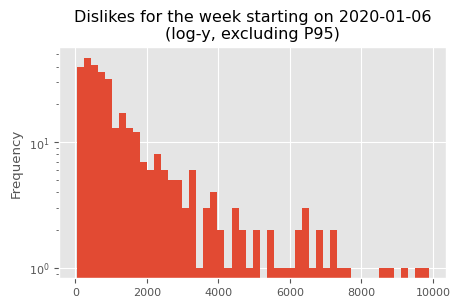

In [15]:
vis_dislikes.plot.hist(
    title="Dislikes for the week starting on 2020-01-06\n(log-y, excluding P95)",
    bins=50,
    logy=True,
);

#### Transformed value

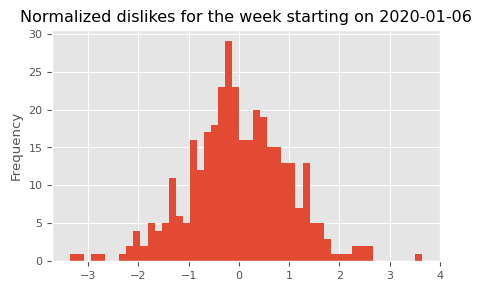

In [16]:
weekly_dislikes["norm_dislikes"].plot.hist(
    title="Normalized dislikes for the week starting on 2020-01-06",
    bins=50,
);

# Graphs

## Null Model

The null model is a random graph with the same number of nodes and edges. We use the stats of such a graph as the baseline to compare with real-world network stats, in particular the average clustering coefficient, which is expected to be higher on the real-world network.

In [17]:
graph_stats = pd.read_sql_query(
    sql="""
        SELECT
            'num_nodes' AS stat,
            count(*) AS val
        FROM graph.nodes
        
        UNION
        
        SELECT
            'num_edges' AS stat,
            count(*) AS val
        FROM graph.edges
    """,
    con=pg_conn_str,
).set_index("stat")

graph_stats

,val
stat,
num_edges,171002
num_nodes,22470


In [18]:
n = graph_stats.loc["num_nodes"].item()
m = graph_stats.loc["num_edges"].item()
p = 2 * m / (n * (n - 1))

n, m, p

(22470, 171002, 0.000677398715568023)

In [19]:
%%time
null_model = nx.erdos_renyi_graph(n, p)

CPU times: user 16.1 s, sys: 16.9 ms, total: 16.1 s
Wall time: 16.1 s


In [20]:
null_model_cc = nx.average_clustering(null_model)
null_model_cc

0.0007120984673027632